# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
# pd.set_option('display.max_colwidth', -1)
from matplotlib import pyplot as plt
import seaborn as sns
import keras
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
import sqlite3
from tqdm import tqdm
import re
from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
conn = sqlite3.connect('/content/drive/My Drive/deeplearning/amazon-fine-food-reviews/database.sqlite')
df = pd.read_sql_query(''' SELECT * FROM REVIEWS ''', conn)

print("Number of data points in our data", df.shape)
df.head(3)

Number of data points in our data (568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


## Data Preprocessing

In [4]:
# check for null values
print(df['Score'].isnull().sum())
df['Text'].isnull().sum()  # no null values.

0


0

In [5]:
# remove duplicates/ for every duplicate we will keep only one row of that type. 
df.drop_duplicates(subset=['Score','Text'],keep='first',inplace=True) 
df.shape

(393675, 10)

In [6]:
# printing some reviews to see insights.
for review in df['Text'][:5]:
    print(review+'\n'+'\n')

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".


This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.


If you are looking for the se

In [0]:
# make it a classification problem
def mark_sentiment(rating):
  if(rating<=3):
    return 0
  else:
    return 1

In [8]:
df['Score']=df['Score'].apply(mark_sentiment)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [9]:
df['Score'].value_counts()

1    306819
0     86856
Name: Score, dtype: int64

In [10]:
# Shrink down the data size to 100k in total
pos_df=df.loc[df.Score==1,:][:50000]
neg_df=df.loc[df.Score==0,:][:50000]
pos_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,1,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,1,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...


In [11]:
neg_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
12,13,B0009XLVG0,A327PCT23YH90,LT,1,1,0,1339545600,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...
16,17,B001GVISJM,A3KLWF6WQ5BNYO,Erica Neathery,0,0,0,1348099200,poor taste,I love eating them and they are good for watch...
26,27,B001GVISJM,A3RXAU2N8KV45G,lady21,0,1,0,1332633600,Nasty No flavor,"The candy is just red , No flavor . Just plan..."


In [12]:
# combine them
df=pd.concat([pos_df,neg_df],ignore_index=True)
print(df.shape)

(100000, 10)


In [0]:
filtered_data = df

In [15]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

# #Deduplication of entries
# final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
# final.shape

#Removing the anamolies
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

#Preprocessing
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, features ="html").get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    # sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())
    
## Similartly you can do preprocessing for review summary also.
def concatenateSummaryWithText(str1, str2):
    return str1 + ' ' + str2

preprocessed_summary = []
# tqdm is for printing the status bar
for sentence in tqdm(final['Summary'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    #sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    # sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentence.strip())
    
preprocessed_reviews = list(map(concatenateSummaryWithText, preprocessed_reviews, preprocessed_summary))
final['CleanedText'] = preprocessed_reviews
final['CleanedText'] = final['CleanedText'].astype('str')


100%|██████████| 99989/99989 [00:01<00:00, 59769.94it/s]

Segregating the input and output data from the dataset.

We will be using the Cleaned Text i.e preprocessed data from the dataset and score for that text

In [0]:
X = final['CleanedText']
y = final['Score']

In [0]:
del final
del preprocessed_reviews
del preprocessed_summary
del sorted_data
del filtered_data

### Splitting the data

In [17]:
X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.20, stratify=y, shuffle=True)
X_train, X_cv, y_train, y_cv = train_test_split(X_t, y_t, test_size=0.20, stratify=y_t, shuffle=True)
print("Shape of Input  - Train:", X_train.shape)
print("Shape of Output - Train:", y_train.shape)
print("Shape of Input  - CV   :", X_cv.shape)
print("Shape of Output - CV   :", y_cv.shape)
print("Shape of Input  - Test :", X_test.shape)
print("Shape of Output - Test :", y_test.shape)

Shape of Input  - Train: (63992,)
Shape of Output - Train: (63992,)
Shape of Input  - CV   : (15999,)
Shape of Output - CV   : (15999,)
Shape of Input  - Test : (19998,)
Shape of Output - Test : (19998,)


### Tokenizing the dataset

In [18]:
tokenize = Tokenizer(num_words=5000)
tokenize.fit_on_texts(X_train)

X_train_new = tokenize.texts_to_sequences(X_train)
X_cv_new = tokenize.texts_to_sequences(X_cv)
X_test_new = tokenize.texts_to_sequences(X_test)

print(X_train_new[1])
print(len(X_train_new))

[2, 16, 116, 3726, 739, 46, 1090, 44, 1001, 3, 337, 5, 5, 6, 84, 58, 3601, 6, 2600, 514, 3, 70, 424, 320, 8, 210, 525, 409, 122, 357, 1627, 27, 2600, 514, 3, 311, 122, 1595, 60, 2, 118, 1, 85, 119, 7, 95, 30, 6, 7, 87, 178, 8, 1, 140, 2, 87, 71, 7, 8, 1, 2380, 310, 8, 525, 212, 12, 115, 8, 3726, 739, 3, 195, 71, 7, 261, 8, 174, 3, 336, 2273, 40, 445, 71, 388, 38, 25, 2, 365, 5, 159, 20, 1740, 1433, 6, 358, 3466, 409, 3, 780, 2, 128, 65, 6, 4, 177, 8, 106, 3, 268, 266, 152, 5, 6, 4, 177, 173, 58, 525, 409, 3, 741, 60, 59, 3726, 739]
63992


### Padding the dataset

This is just to give batch input to the RNN

In [19]:
# truncate and/or pad input sequences
max_review_length = 1000
X_train_new = sequence.pad_sequences(X_train_new, maxlen=max_review_length)
X_cv_new = sequence.pad_sequences(X_cv_new, maxlen=max_review_length)
X_test_new = sequence.pad_sequences(X_test_new, maxlen=max_review_length)

print(X_train_new.shape)
print(X_train_new[1])

(63992, 1000)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   

In [0]:
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    
n_epochs = 5
batchsize = 512

final_output = pd.DataFrame(columns=["Model", "Architecture",
                                     "TRAIN_LOSS", "TEST_LOSS", "TRAIN_ACC", "TEST_ACC"]);

### Model M1 ( Embedding -> LSTM -> Output(Sigmoid) ) 

In [28]:
# create the model
embed_vector_length = 32
model = Sequential()
model.add(Embedding(5000, embed_vector_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("***********************************************")
print("Printing the Model Summary")
print(model.summary())
print("***********************************************")

***********************************************
Printing the Model Summary
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1000, 32)          160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None
***********************************************





Train on 63992 samples, validate on 15999 samples
Epoch 1/5





63992/63992 [==============================] - 1070s 17ms/step - loss: 0.4449 - acc: 0.7874 - val_loss: 0.2986 - val_acc: 0.8775
Epoch 2/5
63992/63992 [==============================] - 1062s 17ms/step - loss: 0.2675 - acc: 0.8920 - val_loss: 0.2760 - val_acc: 0.8893
Epoch 3/5
63992/63992 [==============================] - 1058s 17ms/step - loss: 0.2410 - acc: 0.9046 - val_loss: 0.2679 - val_acc: 0.8907
Epoch 4/5
63992/63992 [==============================] - 1064s 17ms/step - loss: 0.2241 - acc: 0.9128 - val_loss: 0.2690 - val_acc: 0.8903
Epoch 5/5
19998/19998 [==============================] - 94s 5ms/step
Test score: 0.2655218025781784
Test accuracy: 0.8950395039563561


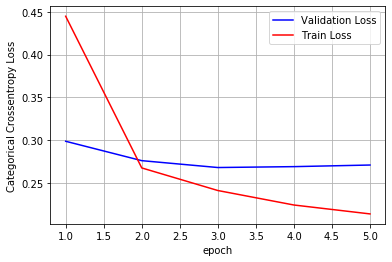

In [23]:
m_hist = model.fit(X_train_new, y_train, epochs=n_epochs, 
                   batch_size=batchsize, verbose=1, validation_data=(X_cv_new, y_cv))

score = model.evaluate(X_test_new, y_test, batch_size=batchsize)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

final_output = final_output.append({"Model": 1,
                                    "Architecture": 'Embedding-LSTM-Sigmoid', 
                                    "TRAIN_LOSS": '{:.5f}'.format(m_hist.history["loss"][n_epochs-1]),
                                    "TEST_LOSS": '{:.5f}'.format(score[0]),
                                    "TRAIN_ACC": '{:.5f}'.format(m_hist.history["acc"][n_epochs-1]),
                                    "TEST_ACC": '{:.5f}'.format(score[1])}, ignore_index=True)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,n_epochs+1))

vy = m_hist.history['val_loss']
ty = m_hist.history['loss']
plt_dynamic(x, vy, ty, ax)

### Model M2 ( Embedding -> LSTM -> Dropout -> Output(Sigmoid) ) 


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
***********************************************
Printing the Model Summary
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1000, 32)          160000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None
***********************************************
Tr

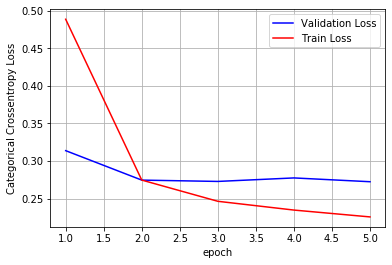

In [29]:
# create the model
embed_vector_length = 32
model = Sequential()
model.add(Embedding(5000, embed_vector_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("***********************************************")
print("Printing the Model Summary")
print(model.summary())
print("***********************************************")

# fit
m_hist = model.fit(X_train_new, y_train, epochs=n_epochs, 
                   batch_size=batchsize, verbose=1, validation_data=(X_cv_new, y_cv))

score = model.evaluate(X_test_new, y_test, batch_size=batchsize)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

final_output = final_output.append({"Model": 3,
                                    "Architecture": 'Embedding-LSTM-Dropout-Sigmoid', 
                                    "TRAIN_LOSS": '{:.5f}'.format(m_hist.history["loss"][n_epochs-1]),
                                    "TEST_LOSS": '{:.5f}'.format(score[0]),
                                    "TRAIN_ACC": '{:.5f}'.format(m_hist.history["acc"][n_epochs-1]),
                                    "TEST_ACC": '{:.5f}'.format(score[1])}, ignore_index=True)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,n_epochs+1))

vy = m_hist.history['val_loss']
ty = m_hist.history['loss']
plt_dynamic(x, vy, ty, ax)

### Model M3 ( Embedding -> LSTM -> Dropout -> Dense(128-Relu) -> Dropout -> Dense (64-Relu) -> Dropout -> Output(Sigmoid) ) 

In [0]:
# create the model
embed_vector_length = 32
model = Sequential()
model.add(Embedding(5000, embed_vector_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dropout(rate=0.5))
model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(rate=0.5))
model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("***********************************************")
print("Printing the Model Summary")
print(model.summary())
print("***********************************************")

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
***********************************************
Printing the Model Summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 32)          160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               12928     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)   

Train on 56614 samples, validate on 14154 samples
Epoch 1/5
56614/56614 [==============================] - 152s 3ms/step - loss: 0.3504 - acc: 0.8643 - val_loss: 0.2107 - val_acc: 0.9106
Epoch 2/5
56614/56614 [==============================] - 150s 3ms/step - loss: 0.1875 - acc: 0.9237 - val_loss: 0.1980 - val_acc: 0.9187
Epoch 3/5
56614/56614 [==============================] - 150s 3ms/step - loss: 0.1651 - acc: 0.9333 - val_loss: 0.2015 - val_acc: 0.9159
Epoch 4/5
56614/56614 [==============================] - 150s 3ms/step - loss: 0.1525 - acc: 0.9382 - val_loss: 0.2152 - val_acc: 0.9205
Epoch 5/5
17693/17693 [==============================] - 15s 855us/step
Test score: 0.21484055181059122
Test accuracy: 0.9195161930265444


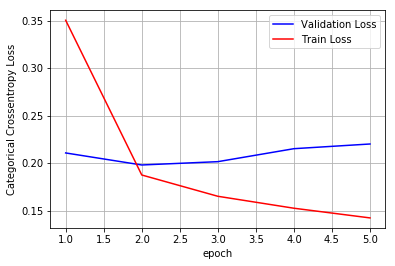

In [0]:
m_hist = model.fit(X_train_new, y_train, epochs=n_epochs, 
                   batch_size=batchsize, verbose=1, validation_data=(X_cv_new, y_cv))

score = model.evaluate(X_test_new, y_test, batch_size=batchsize)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

final_output = final_output.append({"Model": 3,
                                    "Architecture": 'Embedding-LSTM-Dropout-Dense(128-Relu)-Dropout-Dense(64-Relu)-Dropout-Sigmoid', 
                                    "TRAIN_LOSS": '{:.5f}'.format(m_hist.history["loss"][n_epochs-1]),
                                    "TEST_LOSS": '{:.5f}'.format(score[0]),
                                    "TRAIN_ACC": '{:.5f}'.format(m_hist.history["acc"][n_epochs-1]),
                                    "TEST_ACC": '{:.5f}'.format(score[1])}, ignore_index=True)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,n_epochs+1))

vy = m_hist.history['val_loss']
ty = m_hist.history['loss']
plt_dynamic(x, vy, ty, ax)

### Model M4 ( Embedding -> LSTM -> LSTM -> Output(Sigmoid) ) 

In [0]:
# create the model
embed_vector_length = 32
model = Sequential()
model.add(Embedding(5000, embed_vector_length, input_length=max_review_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("***********************************************")
print("Printing the Model Summary")
print(model.summary())
print("***********************************************")

***********************************************
Printing the Model Summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 32)          160000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 1000, 100)         53200     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 293,701
Trainable params: 293,701
Non-trainable params: 0
_________________________________________________________________
None
***********************************************


Train on 56614 samples, validate on 14154 samples
Epoch 1/5
56614/56614 [==============================] - 302s 5ms/step - loss: 0.3526 - acc: 0.8652 - val_loss: 0.2374 - val_acc: 0.9016
Epoch 2/5
56614/56614 [==============================] - 307s 5ms/step - loss: 0.1953 - acc: 0.9186 - val_loss: 0.1999 - val_acc: 0.9166
Epoch 3/5
56614/56614 [==============================] - 306s 5ms/step - loss: 0.1707 - acc: 0.9301 - val_loss: 0.2002 - val_acc: 0.9209
Epoch 4/5
56614/56614 [==============================] - 305s 5ms/step - loss: 0.1533 - acc: 0.9376 - val_loss: 0.1985 - val_acc: 0.9164
Epoch 5/5
17693/17693 [==============================] - 30s 2ms/step
Test score: 0.1957926377801462
Test accuracy: 0.9175380090116707


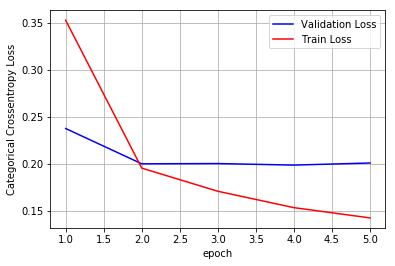

In [0]:
m_hist = model.fit(X_train_new, y_train, epochs=n_epochs, 
                   batch_size=batchsize, verbose=1, validation_data=(X_cv_new, y_cv))

score = model.evaluate(X_test_new, y_test, batch_size=batchsize)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

final_output = final_output.append({"Model": 4,
                                    "Architecture": 'Embedding-LSTM-LSTM-Sigmoid', 
                                    "TRAIN_LOSS": '{:.5f}'.format(m_hist.history["loss"][n_epochs-1]),
                                    "TEST_LOSS": '{:.5f}'.format(score[0]),
                                    "TRAIN_ACC": '{:.5f}'.format(m_hist.history["acc"][n_epochs-1]),
                                    "TEST_ACC": '{:.5f}'.format(score[1])}, ignore_index=True)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,n_epochs+1))

vy = m_hist.history['val_loss']
ty = m_hist.history['loss']
plt_dynamic(x, vy, ty, ax)

# Conclusion

In [0]:
#final_output



The dataset which we used is Amazon fine food reviews dataset.
There are a couple different models that we tried -

Conclusion that can be drawn from the above models is that
all the models are performing great in terms of execution. 